In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
pedestals=pd.read_csv("pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'std_dev', 'mean'])

In [12]:
mips=pd.read_csv("mip.csv", sep=',')
mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [13]:
bars = pd.read_csv('strips.txt', sep=" ", header=None)
bars.columns = ["layer", "strip", "x", "y", "z"]

In [14]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [15]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [16]:
def drop_empty(df):
    events=[]
    adc_0=[]
    adc_1=[]
    l=[]
    s=[]
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end1"]>1.2*peds.iloc[1,-1]] # gets rid of bars where there's no data in end1
                
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1] # subtracting pedestals
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-1]
                
                el.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                el.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event','tot_end0', 'adc_sum_end0', 'layer', 'strip','tot_end1', 'adc_sum_end1'])
    
    return df_s

In [17]:
def get_event(df, event):
    df=df[df["event"]==event]
    return df

In [18]:
# prepping db
electron=pd.read_csv("run_300.csv", sep=',')
electron=electron.drop(columns=['toa_end0', 'toa_end1', 'adc_max_end0', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks'])

electron=electron.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 
electron=drop_empty(electron)

n_all=len(electron.event.unique())

In [19]:
electron=electron[(electron['tot_end0']>0) | (electron['tot_end1']>0)]
n_tot=len(electron.event.unique())

print("Percentage of event that fire TOT: ")
print(str(round(n_tot*100/n_all, 4))+" %")

Percentage of event that fire TOT: 
94.2966 %


In [20]:
tot_by_event=electron.groupby(['event']).count().drop(columns=["layer", "strip","adc_sum_end0", "adc_sum_end1"]).reset_index()

tot_by_bar=electron.groupby(['layer', 'strip']).count().drop(columns=["event", "adc_sum_end0", "adc_sum_end1"]).reset_index()

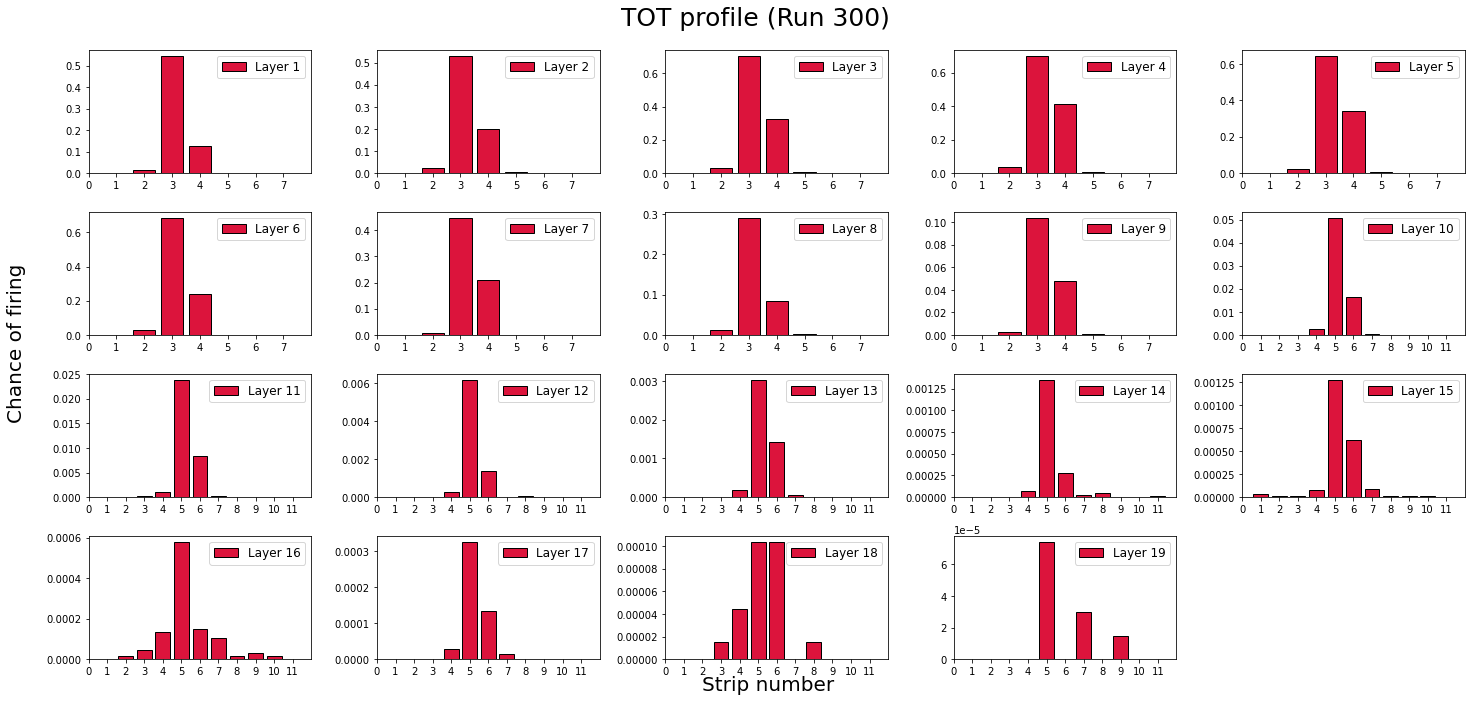

In [27]:
plt.rcParams["figure.figsize"]=(20,9)
for i in range(1,20):
    layered=choose_layer(tot_by_bar, i)
    
    plt.subplot(4,5,i)
    plt.bar(layered["strip"],(layered["tot_end0"]+layered["tot_end1"])/(2*n_tot),
            color='crimson' , edgecolor='black', label="Layer "+str(i))
    plt.legend(fontsize=12)
    if i<10:
        plt.xlim(0,8)
        plt.xticks(np.arange(0,8))
    else:
        plt.xlim(0,12)
        plt.xticks(np.arange(0,12))
    # if i<11:
    #     plt.ylim(0,50000)
    # elif i<11:
    #     plt.ylim(0,0.7)
    # elif i<16:
    #     plt.ylim(0,2000)
    # else:
    #     plt.ylim(0,50)
plt.tight_layout()
plt.text(-10, -2e-5, 'Strip number', ha='center', fontsize=20)
plt.text(-51, 2e-4, 'Chance of firing', va='center', rotation='vertical', fontsize=20)
plt.suptitle("TOT profile (Run 300)", y=1.05, fontsize=25)
plt.savefig("run_300_tot_bar_chance.png", bbox_inches='tight')
plt.show()

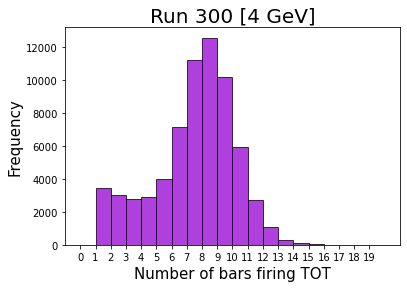

In [24]:
plt.rcParams["figure.figsize"]=(6,4)

plt.hist((tot_by_event["tot_end0"]+tot_by_event["tot_end1"])/(2), range=(0,20), bins=20,
         color="darkviolet", edgecolor='black', alpha=0.75)
plt.xticks(np.arange(0,20))
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Number of bars firing TOT", fontsize=15)
plt.title("Run 300 [4 GeV]", fontsize=20)
#plt.savefig("run_300_tot_event.png", bbox_inches='tight')
plt.show()

In [28]:
data, bins=np.histogram((tot_by_event["tot_end0"]+tot_by_event["tot_end1"])/(2), range=(0,20), bins=20)

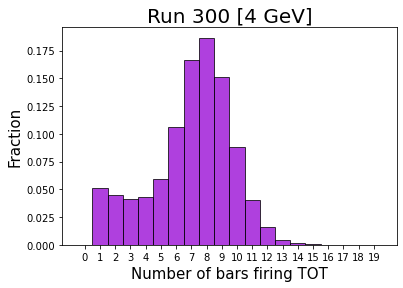

In [45]:
plt.bar(bins[:-1], data/n_tot, color="darkviolet", edgecolor="black", alpha=0.75, width=1)
plt.xticks(np.arange(0,20))
plt.ylabel("Fraction", fontsize=15)
plt.xlabel("Number of bars firing TOT", fontsize=15)
plt.title("Run 300 [4 GeV]", fontsize=20)
plt.savefig("run_300_tot_event_percent.png", bbox_inches='tight')
plt.show()